In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
components = np.loadtxt('../dependencies.txt', delimiter=",");

In [3]:
components.shape

(10440, 3)

In [4]:
np.sum(np.where(components[:, 2] > 0.1, 1, 0))

646

In [5]:
def draw_by_prob(prob):
    G = nx.Graph()
    nodes_with_edges = set()
    for (u, v, w) in components:
        if w > prob:
            G.add_edge(int(u), int(v), weight=w)
            nodes_with_edges.add(int(u))
            nodes_with_edges.add(int(v))
        if not u in G.nodes:
            G.add_node(int(u))
    all_weights = []
    for (node1,node2,data) in G.edges(data=True):
            all_weights.append(data['weight'])
    unique_weights = list(set(all_weights))
    if prob > 0.1:
         fig = plt.figure(0, (12, 3))
    else:
         fig = plt.figure(0, (12, 12))

    for i, subgraph in enumerate(nx.connected_components(G)):
        if len(subgraph) == 1:
             continue
        subgraph = nx.subgraph(G, subgraph)
        pos = nx.circular_layout(subgraph)
        pos = {k: (v[0]+i*2, v[1]) for k, v in pos.items()}
        for weight in unique_weights:
            weighted_edges = [(u, v) for (u, v, w) in G.edges(data=True) if w['weight'] == weight and (u in subgraph.nodes)]
            width = weight
            nx.draw_networkx_edges(subgraph, pos, edgelist=weighted_edges, width=width)
            nx.draw_networkx_nodes(subgraph, pos, node_size=100)
            nx.draw_networkx_labels(subgraph, pos, font_size=6, font_color='k')
    print(list(nodes_with_edges))
    print(len(nodes_with_edges))
    plt.box(False)
    plt.savefig("prob_{}.pdf".format(prob))
    plt.clf()

In [6]:
# for i in np.arange(0, 0.6, 0.1):
#     draw_by_prob(i)

In [7]:
import pandas as pd
df = pd.read_csv('../experiments_random_map.csv')

In [8]:
df['runtime']
df['solver name']

0        CG+GR+GC+T+BP with AStarand Decomp
1           CG+GR+T+BP with AStarand Decomp
2       WDG+GR+GC+T+BP with AStarand Decomp
3           CG+GR+T+BP with AStarand Decomp
4       WDG+GR+GC+T+BP with AStarand Decomp
                       ...                 
9138        CG+GR+T+BP with AStarand Decomp
9139                  CG+GR+T+BP with AStar
9140                  CG+GR+T+BP with AStar
9141                  CG+GR+T+BP with AStar
9142        CG+GR+T+BP with AStarand Decomp
Name: solver name, Length: 9143, dtype: object

In [9]:
list(df.head(1))

['solutionFound',
 'runtime',
 '#high-level expanded',
 '#high-level generated',
 '#low-level expanded',
 '#low-level generated',
 'solution cost',
 'min f value',
 'root g value',
 'root f value',
 '#adopt bypasses',
 'standard conflicts',
 'rectangle conflicts',
 'corridor conflicts',
 'target conflicts',
 'mutex conflicts',
 '#merge MDDs',
 '#solve 2 agents',
 '#memoization',
 'runtime of building heuristic graph',
 'runtime of solving MVC',
 'runtime of detecting conflicts',
 'runtime of rectangle conflicts',
 'runtime of corridor conflicts',
 'runtime of mutex conflicts',
 'runtime of building MDDs',
 'runtime of building constraint tables',
 'runtime of building CATs',
 'runtime of path finding',
 'runtime of generating child nodes',
 'preprocessing runtime',
 'solver name',
 'instance name',
 'number of agents',
 'decompTime',
 'MaxCompRuntime',
 'DecompThreshold',
 'initialRuntime',
 'Unnamed: 38']

In [10]:
decomp = df[df['solver name'].str.contains('Decomp')]
standard = df[df['solver name'].str.contains('Decomp')==False]

In [11]:
len(decomp)

6320

In [12]:
len(standard)

2823

In [13]:
set(df['instance name'].str + df['k'])

KeyError: 'k'

In [150]:
import pandas as pd
import numpy as np
from scipy import stats
plt.rcParams.update({'font.size': 16})
def make_plots(data):
    data['fullSolverName'] = data['solver name'] + data['DecompThreshold'].astype(str)
    unique_solver_names = data['fullSolverName'].unique()
    unique_solver_names = [s  for s in unique_solver_names if 'WDG+GR+GC+' in s]
    # print(unique_solver_completed)
    unique_num_agents = data['number of agents'].unique()
    completed_count = {(num_agents, solver): 0 for num_agents in unique_num_agents for  solver in unique_solver_names}
    total_count = {(num_agents, solver): 25 for num_agents in unique_num_agents for solver in unique_solver_names}
    # Only did decomp once per instance and then stashed the files, so sometimes its 0 decomp time
    max_decomp_time = data.groupby(['number of agents', 'instance name', 'DecompThreshold'])['decompTime'].transform('max')
    data['decompTime'] = max_decomp_time / 12  # Divide by number of cores to get parallel comp time...
    decomp_time = {(num_agents, solver): 0 for num_agents in unique_num_agents for solver in unique_solver_names}
    solution_time = {(num_agents, solver): 0 for num_agents in unique_num_agents for solver in unique_solver_names}

    for index, row in data.iterrows():
        solver = row['fullSolverName']
        if solver not in unique_solver_names:
            continue
        num_agents = row['number of agents']
        if row['solutionFound'] == 1:
            # if row['runtime'] + row['decompTime'] < 60: # Cutoff if decomp time caused issue
            completed_count[(num_agents, solver)] = completed_count.get((num_agents, solver), 0) + 1
            decomp_time[(num_agents, solver)] += row['decompTime']
            solution_time[(num_agents, solver)] += row['runtime'] + row['decompTime']
        # total_count[(num_agents, solver)] = total_count.get((num_agents, solver), 0) + 1
    # print(stats.mode(completed_count.values()))
    import matplotlib.pyplot as plt

    completion_rate = {(num_agents, solver): min(1, completed_count[(num_agents, solver)] / total_count[(num_agents, solver)]) if total_count[(num_agents, solver)] !=0 else 0 for (num_agents, solver) in completed_count }
    print(total_count)
    plt.clf()
    # print(total_count)
    algorithms = list(sorted(unique_solver_names))
    algorithms.append(algorithms.pop(0))
    for algorithm in algorithms:
        if 'Decomp' not in algorithm:
            linestyle = '--'
        else:
            linestyle = '-'
        # if total_count[(num_agents, solver)] < 5:
        #     continue
        x = [num_agents for (num_agents, solver) in sorted(completion_rate) if solver == algorithm and total_count[(num_agents, solver)] > 5]
        # y = [completion_rate[(num_agents, solver)] for (num_agents, solver) in sorted(completion_rate) if solver == algorithm and total_count[(num_agents, solver)] > 5]
        y = [decomp_time[(num_agents, solver)] / solution_time[(num_agents, solver)] for (num_agents, solver) in sorted(completion_rate) if solver == algorithm  if solution_time[(num_agents, solver)] > 0]
        for i in range(len(x) - 1, -1, -1):
            if i >= len(y):
                break
            if y[i] == 0:
                del x[i]
                del y[i]
        x.append(x[-1] + 5)
        y.append(0)
        if '0.1' in algorithm:
            plt.plot(x, y, label='Decomp.    =0.1', linestyle=linestyle)
        elif '0.2' in algorithm:
            plt.plot(x, y, label='Decom.    =0.2', linestyle=linestyle)
        elif 'Decomp' in algorithm:
            plt.plot(x, y, label='Decomp.    =0.0', linestyle=linestyle)
        else:
            algorithm_label = algorithm # 'CBSH-RTC'
            plt.plot(x, y, label=algorithm_label, linestyle=linestyle)
        print(x, y)
    plt.xlabel('Number of Agents')
    plt.ylabel('Completion Rate')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # if len(x) == 0:
    #     return
    plt.savefig('brc_decomp_time.pdf')

/tmp/ipykernel_177440/1541061622.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fullSolverName'] = data['solver name'] + data['DecompThreshold'].astype(str)
/tmp/ipykernel_177440/1541061622.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decompTime'] = max_decomp_time / 12  # Divide by number of cores to get parallel comp time...


{(5, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (5, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (5, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (5, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (10, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (10, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (10, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (10, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (15, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (15, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (15, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (15, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (20, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (20, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (20, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (20, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (25, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (25, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (25, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (25, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (30, 'WDG+GR+

ValueError: x and y must have same first dimension, but have shapes (81,) and (20,)

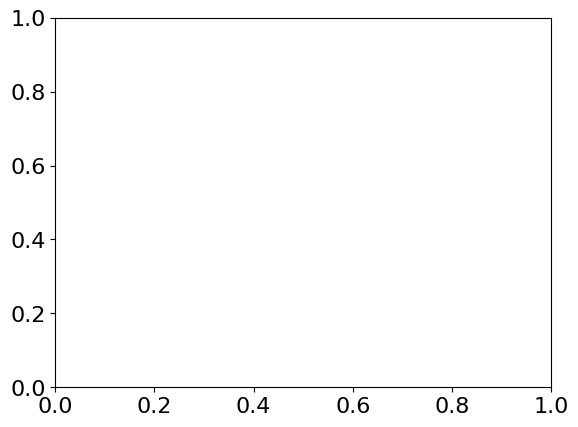

In [151]:
all_data = pd.read_csv('../experiments_boston_3.csv')
# all_data = pd.read_csv('experiments_maze.csv')
column_names = all_data.columns.tolist()
# map_types = ['Boston', 'brc2', 'den312']
map_types = ['brc2']
# map_types = ['maze']
for m in map_types:
    data = all_data[all_data['instance name'].str.contains(m)]
    make_plots(data)

In [139]:
all_data = pd.read_csv('../bost_experiments.csv')
# all_data = pd.read_csv('experiments_maze.csv')
column_names = all_data.columns.tolist()
# map_types = ['Boston', 'brc2', 'den312']
# map_types = ['brc2']
map_types = ['Boston']
# map_types = ['maze']
for m in map_types:
    data = all_data[all_data['instance name'].str.contains(m)]
    make_plots(data)

{(5, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (5, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (5, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (5, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (10, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (10, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (10, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (10, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (15, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (15, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (15, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (15, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (20, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (20, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (20, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (20, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (25, 'WDG+GR+GC+T+BP with AStarand Decomp0.0'): 25, (25, 'WDG+GR+GC+T+BP with AStarand Decomp0.1'): 25, (25, 'WDG+GR+GC+T+BP with AStarand Decomp0.2'): 25, (25, 'WDG+GR+GC+T+BP with AStar0.0'): 25, (30, 'WDG+GR+

NameError: name 'solver_time' is not defined

<Figure size 640x480 with 0 Axes>

In [127]:
def make_sorted_runtimes(algorithms, data):
    # data: algorithm -> list of runtimes

    # For each algorithm
    for a in data.keys():
        # For all runtimes, sort
        runtimes = sorted(data[a])
        # get line style and color...

        plt.plot(runtimes, np.arange(1, len(runtimes) + 1), label=a)

    plt.xlabel('Time (s)')
    plt.ylabel('Instances Solved')
    # plt.legend()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xscale('log')
def df_to_runtimes(dataframe):

    unique_solver_names = dataframe['fullSolverName'].unique()
    algorithms = [s  for s in unique_solver_names if 'WDG+GR+GC+' in s]
    # algorithms = dataframe['fullSolverName'].unique()
    print((dataframe['runtime'] + dataframe['decompTime']).mean())
    data = {a: [] for a in algorithms}
    for index, row in dataframe.iterrows():
        if row['fullSolverName'] not in algorithms:
            continue
        if row['solutionFound'] == 1 and float(row['runtime']) + float(row['decompTime']) < 60:
            runtime = float(row['runtime']) + float(row['decompTime'])
            print(row['decompTime'])
            # if row['runtime'] + row['decompTime'] < 60: # Cutoff if decomp time caused issue
            data[row['fullSolverName']].append(runtime)
    return data

In [128]:
def preprocess_df(dataframe):
    dataframe['fullSolverName'] = dataframe['solver name'] + dataframe['DecompThreshold'].astype(str)
    # Only did decomp once per instance and then stashed the files, so sometimes its 0 decomp time
    max_decomp_time = dataframe.groupby(['number of agents', 'instance name', 'DecompThreshold'])['decompTime'].transform('max')
    dataframe['decompTime'] = max_decomp_time  # Divide by number of cores to get parallel comp time...
    print(dataframe['decompTime'].mean())

    return dataframe

66.43434598643869
70.91838499896815
1.71474
1.75397
3.96434
1.70183
1.71474
0.504938
0.669907
0.460622
0.504938
0.842178
4.00455
0.8382
0.835699
0.842178
0.632529
0.609023
0.625561
0.632529
3.89875
3.96434
0.988748
0.945538
1.02168
0.988748
0.826549
3.89757
0.740374
0.757281
0.826549
0.279744
0.323174
0.28597
0.279744
3.7133
3.60181
3.68002
3.89757
3.61527
3.6157
3.60181
5.74282
2.17076
2.0831
2.05147
2.17076
0.33001
5.80542
0.376228
0.324318
0.33001
0.793653
0.782529
0.791789
0.793653
0.889392
0.922853
5.94489
5.74282
0.901616
0.889392
0.82816
0.753919
0.71478
0.82816
0.791464
0.822385
0.759846
0.791464
0.72059
0.716525
0.75456
0.72059
0.470254
0.471753
0.452809
0.470254
0.249531
0.244694
0.268529
0.249531
0.245776
0.238762
10.1776
0.246901
0.245776
0.43695
0.432212
0.452628
0.43695
0.930108
0.944115
0.908061
0.930108
0.766439
0.763104
0.794238
0.766439
0.400204
0.440548
0.490657
0.400204
0.424557
0.396814
0.43532
0.424557
1.08024
1.06567
1.10566
1.08024
0.670221
0.666519
0.652264
0.6

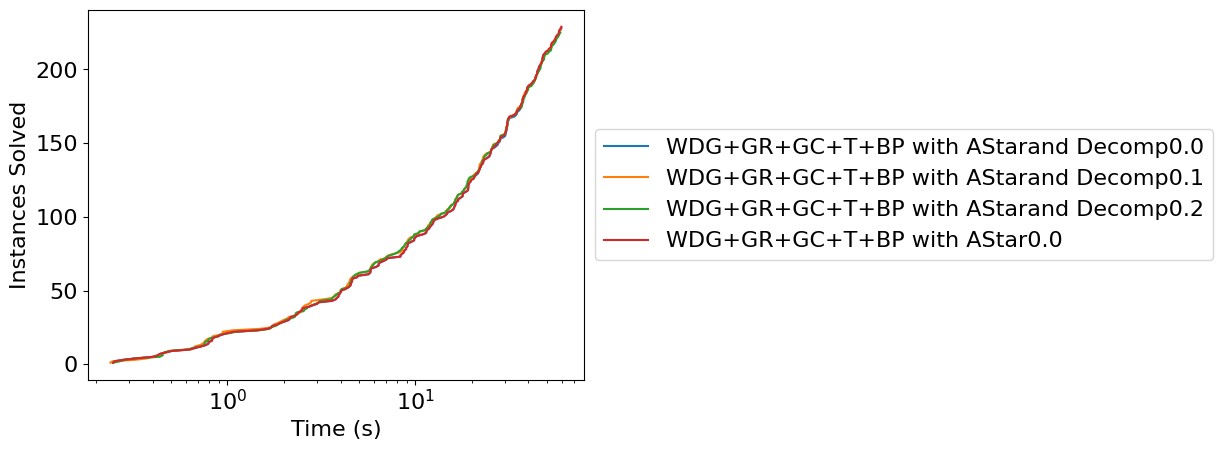

In [129]:
all_data = pd.read_csv('../bost_experiments.csv')
# all_data = pd.read_csv('experiments_maze.csv')
column_names = all_data.columns.tolist()
# map_types = ['Boston', 'brc2', 'den312']
map_types = ['Boston']
# map_types = ['maze']
for m in map_types:
    all_data = all_data[all_data['instance name'].str.contains(m)]
    df = preprocess_df(all_data)
    runtimes_data = df_to_runtimes(df)
    make_sorted_runtimes(df['fullSolverName'], runtimes_data)

In [ ]:
def compute_avg_decomp_time(data):
    filtered_data = data.loc(data['number of agents'] % 5 == 0)
    avg_decomp_time = filtered_data.groupby('number of agents')['decompTime'].mean()
    print(avg_decomp_time)